In [24]:
import os
import numpy as np
import scipy.stats as st
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rc('figure', dpi=200)
plt.rc('legend', fontsize=9)
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [55]:
def concatenate_performance(dir_path):
    path = Path(dir_path)
    (_, dir_names, _) = next(os.walk(path))  # Get subdirectories
    memmaps = []
    for sweep_dir in [d for d in dir_names if d.startswith("sweep")]:  # Filter for "sweep" prefix
        # Open the performance memmaps in each subdirectory:
        memmaps.append(np.lib.format.open_memmap(str(path / sweep_dir / 'performance.npy'), mode='r'))
    concatenated = np.concatenate(memmaps)  # concatenate all memmaps together (note: loads them all into memory)
    del memmaps
    performance_memmap = np.lib.format.open_memmap(str(path / 'concatenated_performance.npy'), shape=concatenated.shape, dtype=concatenated.dtype, mode='w+')
    performance_memmap[:] = concatenated
    del concatenated
    del performance_memmap
    
def combine_results(results):
    num_configs, num_runs, num_policies, num_evals = results.shape
    mean_evals = np.mean(results, axis=3)
    mean_runs = np.mean(mean_evals, axis=1)
    sem_runs = st.sem(mean_evals, axis=1)
    lower, upper = st.t.interval(0.95, num_runs-1, loc=mean_runs, scale=sem_runs)
    return mean_runs, lower, upper

def load_performance(alg):
    return np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/virtual-office3/'+alg+'/concatenated_performance.npy', mode='r')

In [72]:
# etd_algs = ['ace-trace-etd-episodic', 'ace-trace-etd-uniform', 'offpac-etd',  'ace-direct-etd-uniform']
# tdrc_algs = ['ace-trace-tdrc-episodic', 'ace-trace-tdrc-uniform', 'offpac-tdrc', 'ace-direct-tdrc-uniform']
etd_algs = ['ace-trace-etd-episodic', 'ace-trace-etd-uniform', 'offpac-etd', 'ace-direct-etd-episodic', 'ace-direct-etd-uniform']
tdrc_algs = ['ace-trace-tdrc-episodic', 'ace-trace-tdrc-uniform', 'offpac-tdrc', 'ace-direct-tdrc-episodic', 'ace-direct-tdrc-uniform']
algs = etd_algs + tdrc_algs

# for alg in algs:
#     concatenate_performance('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/virtual-office5/' + alg)
#     print(alg)

ace-trace-etd-episodic (0.0625, 0.125, 0., 0., 1., 0.95)
ace-trace-etd-uniform (0.00097656, 0.03125, 0., 0., 1., 0.95)
offpac-etd (0.015625, 0.015625, 0., 0., 0., 0.95)
ace-direct-etd-episodic (0.0625, 0.125, 1., 0., 1., 0.95)
ace-direct-etd-uniform (0.00097656, 0.03125, 1., 0., 1., 0.95)


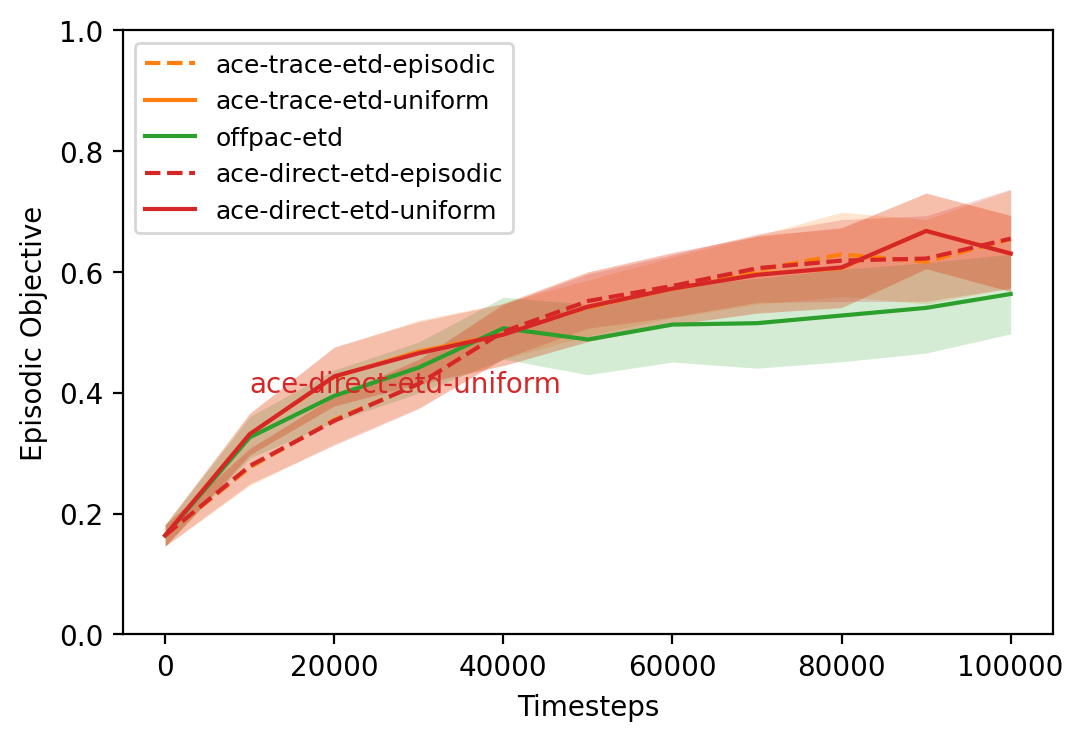

In [74]:
fig, ax = plt.subplots()
for alg in etd_algs:
    performance = load_performance(alg)
    results = performance['results']
    means, lower, upper = combine_results(results['episodic'])
    del results
    best_config = np.nanargmax(means.sum(axis=1))
    print(alg, performance[best_config]['parameters'])
    
    x = np.linspace(0, 100000, means.shape[1])
    y = means[best_config]
    
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, xy=(10000, .4), color=color)
#         elif 'episodic' in alg:
#             ax.annotate(alg, xy=(28000, -1000), xytext=(10000, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'trace' in alg:
        color = 'tab:orange'
#         if 'uniform' in alg:
#             ax.annotate(alg, xy=(21500, -345), xytext=(20000, -480), color=color, arrowprops=dict(arrowstyle="->", color=color))
#         elif 'episodic' in alg:
#             ax.annotate(alg, xy=(80000, -1000), xytext=(60000, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'offpac' in alg:
        color = 'tab:green'
#         ax.annotate(alg, xy=(5500, -600), xytext=(15000, -700), color=color, arrowprops=dict(arrowstyle="->", color=color))
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Episodic Objective')
ax.set_ylim(0,1)
ax.legend(loc="upper left")
plt.savefig('vo_epi_etd.png', bbox_inches="tight")

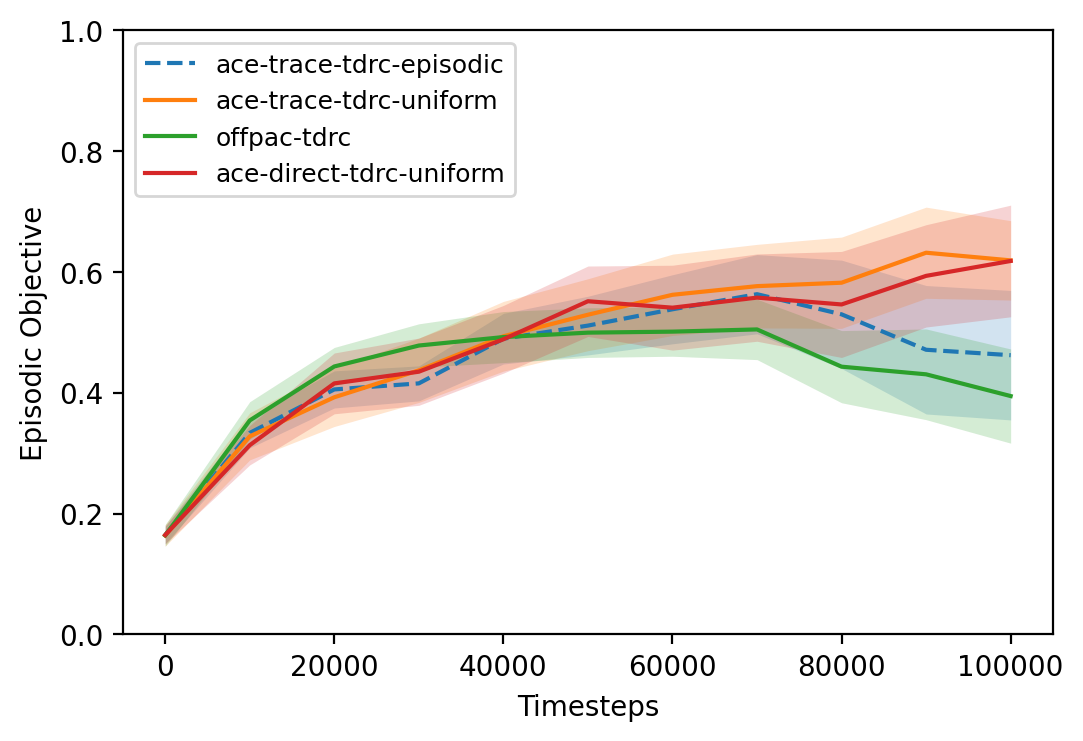

In [67]:
fig, ax = plt.subplots()
for alg in tdrc_algs:
    performance = load_performance(alg)
    results = performance['results']
    means, lower, upper = combine_results(results['episodic'])
    del results
    best_config = np.nanargmax(means.sum(axis=1))
    
    x = np.linspace(0, 100000, means.shape[1])
    y = means[best_config]
    
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Episodic Objective')
ax.set_ylim(0,1)
ax.legend(loc="upper left")
plt.savefig('vo_epi_tdrc.png', bbox_inches="tight")

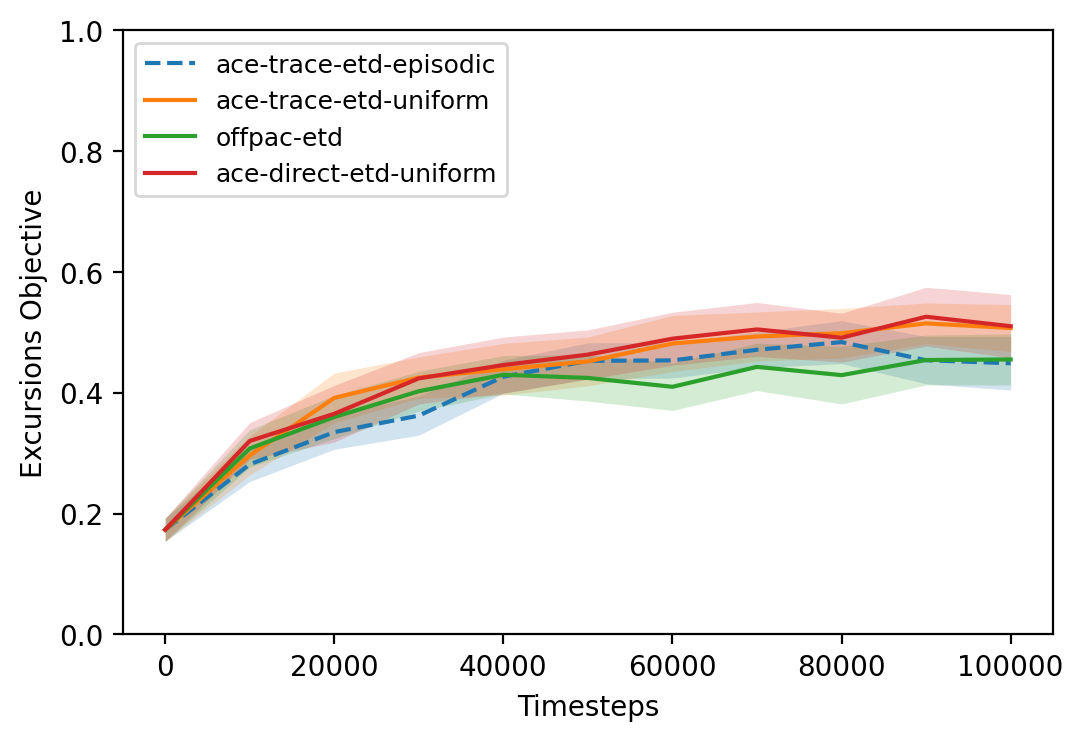

In [66]:
fig, ax = plt.subplots()
for alg in etd_algs:
    performance = load_performance(alg)
    results = performance['results']
    means, lower, upper = combine_results(results['excursions'])
    del results
    best_config = np.nanargmax(means.sum(axis=1))
    x = np.linspace(0, 100000, means.shape[1])
    y = means[best_config]
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Excursions Objective')
ax.set_ylim(0,1)
ax.legend(loc="upper left")
plt.savefig('vo_exc_etd.png', bbox_inches="tight")

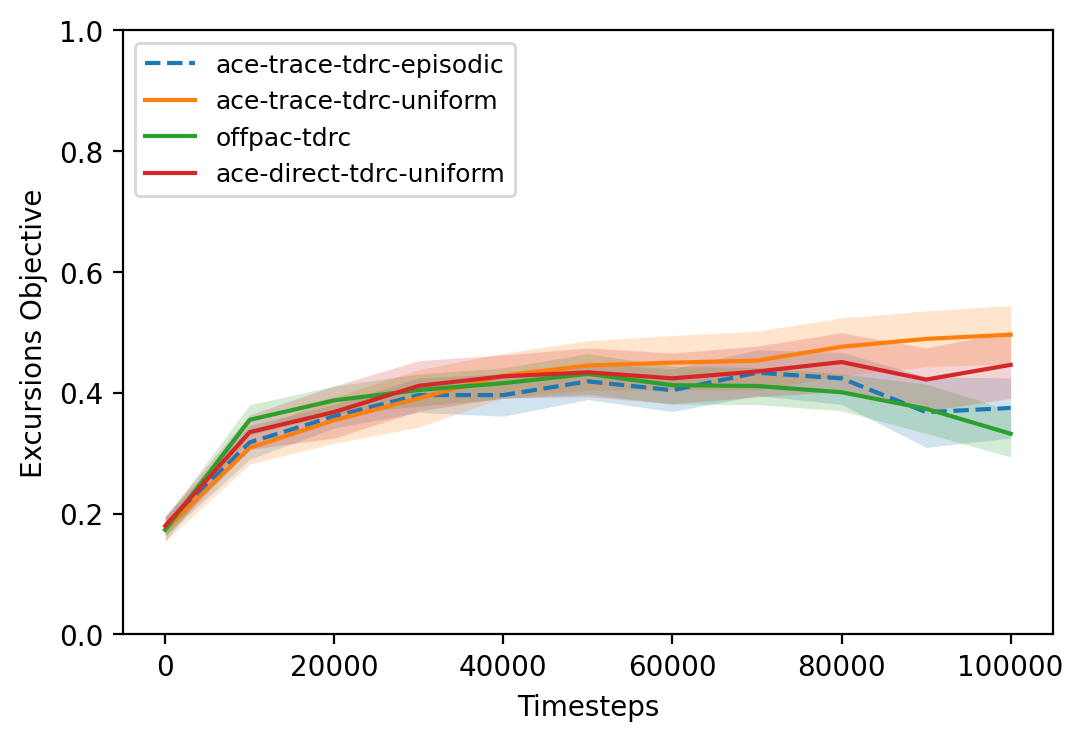

In [65]:
fig, ax = plt.subplots()
for alg in tdrc_algs:
    performance = load_performance(alg)
    results = performance['results']
    means, lower, upper = combine_results(results['excursions'])
    del results
    best_config = np.nanargmax(means.sum(axis=1))
    x = np.linspace(0, 100000, means.shape[1])
    y = means[best_config]
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Excursions Objective')
ax.set_ylim(0,1)
ax.legend(loc="upper left")
plt.savefig('vo_exc_tdrc.png', bbox_inches="tight")

In [70]:
# Code to visualize state visits of different policies:
import gym
import gym_virtual_office
import numpy as np

num_timesteps = 100000

# mu = np.array([.15,.45,.35,.05])  # virtual-office5 (.25, .75) (nothing appears to learn)
# mu = np.array([.235,.3,.265,.2])  # virtual-office4 (.43, .57) (everything appears to learns)
# mu = np.array([.235,.45,.265,.05])  # (.459, .541)
mu = np.array([.2,.45,.3,.05])  # (.362, .638)
state_visits = np.zeros((9,9))

env = gym.make('VirtualOffice-v0').unwrapped
env.seed(14)
rng = env.np_random

env.reset()
assert type(env.agent_pos) is tuple
state_visits[env.agent_pos] += 1
for t in range(num_timesteps):
    a_t = rng.choice(env.action_space.n, p=mu)
    _, r_tp1, terminal, _ = env.step(a_t)

    assert type(env.agent_pos) is tuple
    state_visits[env.agent_pos] += 1
    
    if terminal:
        o_tp1 = env.reset()
        assert type(env.agent_pos) is tuple
        state_visits[env.agent_pos] += 1

# state_visits /=  np.sum(state_visits)
state_visits = state_visits.T
print(state_visits)

top_goal = state_visits[1,7] + state_visits[5,7]
bottom_goal = state_visits[3,7] + state_visits[7,7]
print(top_goal/(top_goal+bottom_goal), bottom_goal/(top_goal+bottom_goal))

[[    0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.   111.   407.  1848.     0.   357.   440.   358.     0.]
 [    0.   319.   779.  2313.  2105.  1256.   889.   756.     0.]
 [    0.  1192.  1907.  6562.     0.   623.   742.   546.     0.]
 [    0.  4659.  3780. 10140.     0.     0.     0.     0.     0.]
 [    0.  1762.  2866. 10171.     0.  1016.  1140.   909.     0.]
 [    0.   727.  1924.  6508.  6242.  3630.  2533.  1974.     0.]
 [    0.   513.  1919. 11761.     0.  1865.  2276.  1688.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.     0.]]
0.3618966009711511 0.6381033990288489
